In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset
from pathlib import Path
import os
from PIL import Image
from torchmetrics.functional.classification import accuracy



from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl


import matplotlib.pyplot as plt
import torchvision.utils as vutils
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from torchvision import datasets


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#!git clone --recursive https://github.com/parlance/ctcdecode.git
#!cd ctcdecode && pip install .
!pip install fast-ctc-decode
#!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.2/622.2 kB 13.0 MB/s eta 0:00:00


In [3]:
#from ctcdecode import CTCBeamDecoder
from fast_ctc_decode import beam_search
#import jiwer
#from torch.utils.tensorboard import SummaryWriter

In [4]:
#alphabet = ["0","1","2","3","4","5","6","7","8","9"]

# Data Loader

In [5]:
class OCRDataset(Dataset):
    def __init__(self,
                 base_path='./data',
                 csv='./data/train.csv',
                 chars = None):
        self.df = pd.read_csv(csv)
        self.df['text'] = self.df['text'].apply(lambda x: x.replace('str', ''))

        self.image_paths = [ Path(os.path.join(base_path, file_name)) for file_name in self.df['file_path'].values ]

        self.chars = [' ']
        if chars is None:
            data_chars = sorted(list(set(''.join([val for val in self.df['text'].values]))))
            self.chars.extend(data_chars)
            self.transforms=T.Compose([
                     T.Resize(size=(64, 128)),
                     T.ToTensor()
                 ])
        else:
            self.chars = chars
            self.transforms=T.Compose([
                     T.Resize(size=(64, 128)),
                     T.ToTensor()
                 ])

        self.max_len = max([ len(text) for text in self.df['text'] ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path)
        img = self.transforms(img)
        text = self.df['text'].values[idx]
        length = self.df['subset'].values[idx]

        text_encoding = torch.zeros(size=(self.max_len,), dtype=torch.long)
        for sample_ind, char in enumerate(text):
            char_ind = self.chars.index(char)
            text_encoding[sample_ind] += char_ind

        return img, text_encoding, torch.tensor(length, dtype=torch.long)

## Loading Test Data

In [6]:
import glob

# search all files inside a specific folder
# *.* means file name with any extension
dir_path = r'/kaggle/input/physdl2023comp2/dataset/*/test/*.jpg'
test_list = []
len_list = []
for file in glob.glob(dir_path, recursive=True):
    test_list.append(file)
    len_list.append(int(file[38]))
df_test = pd.DataFrame({'file_path':test_list, 'text': 'strNaN','subset' : len_list })

In [7]:
df_test.to_csv('/kaggle/working/test.csv',index=False)

In [8]:
test_ds = OCRDataset(base_path='/kaggle/working/',csv='/kaggle/working/test.csv')

## Loading Train Data

In [9]:
train_dir = '/kaggle/input/physdl2023comp2/dataset/train.csv'
dataset_dir = '/kaggle/input/physdl2023comp2/dataset'
train_ds = OCRDataset(base_path=dataset_dir,csv=train_dir)

In [10]:
train_dataset, val_dataset = random_split(train_ds, [int(train_ds.__len__()*0.80), int(train_ds.__len__()*0.20+1)])

In [11]:
i_testimage = 11
train_dataset[i_testimage]

(tensor([[[0.9765, 0.9882, 0.9686,  ..., 0.9765, 0.9882, 0.9961],
          [1.0000, 1.0000, 0.9725,  ..., 1.0000, 0.9490, 0.9059],
          [0.9647, 0.9137, 0.8627,  ..., 0.9647, 0.8000, 0.6431],
          ...,
          [0.9647, 0.9137, 0.8627,  ..., 0.9647, 0.8000, 0.6431],
          [1.0000, 1.0000, 0.9725,  ..., 1.0000, 0.9490, 0.9059],
          [0.9765, 0.9882, 0.9686,  ..., 0.9765, 0.9882, 0.9961]],
 
         [[0.9765, 0.9882, 0.9686,  ..., 0.9765, 0.9882, 0.9961],
          [1.0000, 1.0000, 0.9725,  ..., 1.0000, 0.9490, 0.9059],
          [0.9647, 0.9137, 0.8627,  ..., 0.9647, 0.8000, 0.6431],
          ...,
          [0.9647, 0.9137, 0.8627,  ..., 0.9647, 0.8000, 0.6431],
          [1.0000, 1.0000, 0.9725,  ..., 1.0000, 0.9490, 0.9059],
          [0.9765, 0.9882, 0.9686,  ..., 0.9765, 0.9882, 0.9961]],
 
         [[0.9765, 0.9882, 0.9686,  ..., 0.9765, 0.9882, 0.9961],
          [1.0000, 1.0000, 0.9725,  ..., 1.0000, 0.9490, 0.9059],
          [0.9647, 0.9137, 0.8627,  ...,

In [12]:
#print(train_ds.__getitem__(i_testimage))
#plt.imshow(train_ds.__getitem__(i_testimage)[0].permute(1, 2, 0) , cmap='gray')

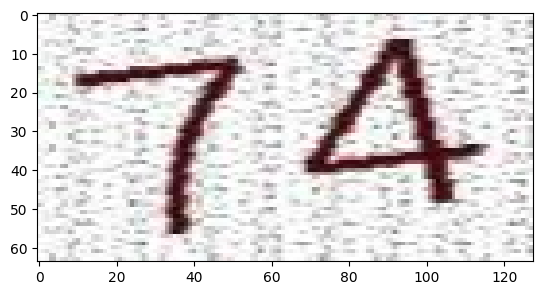

In [13]:
plt.imshow(train_dataset[i_testimage][0].permute(1, 2, 0) , cmap='gray')

In [14]:
train_dataset[i_testimage][0].shape

torch.Size([3, 64, 128])

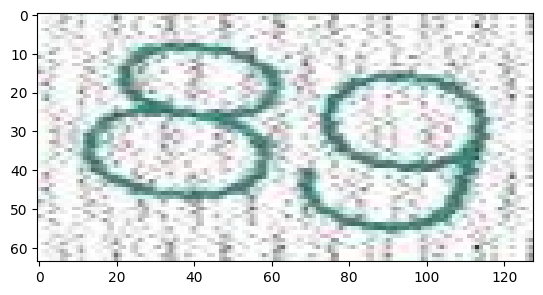

In [15]:
plt.imshow(test_ds.__getitem__(i_testimage)[0].permute(1, 2, 0) , cmap='gray')

# Neural Network

In [16]:
batch_size = 32
num_epochs = 200
num_workers = 2

https://arxiv.org/pdf/1312.6082.pdf

In [17]:
train_dl =  DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=True
        )

val_dl = DataLoader(
            val_dataset,
            batch_size=1,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=True
    )

test_dl = DataLoader(
            test_ds,
            batch_size=1,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=False
    )

In [18]:
#writer = SummaryWriter('/kaggle/working/lightning_logs')
from pytorch_lightning.loggers import TensorBoardLogger

In [19]:
logger = TensorBoardLogger('logs/')  # Set the log directory

In [20]:
class CNN_Classificator(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(3, 16 * 3, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=16 * 3),
            nn.ReLU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout(0.2),

            nn.Conv2d(16 * 3, 22 * 3, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=22 * 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2),

            nn.Conv2d(22 * 3, 44 * 3, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=44 * 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2),

            nn.Conv2d(44 * 3, 54 * 3, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=54 * 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2),

            nn.Conv2d(54 * 3, 64 * 3, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=64 * 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2),

            
            nn.Conv2d(64 * 3, 74 * 3, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=74 * 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2),

            
            nn.Conv2d(74 * 3, 84 * 3, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=84 * 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2),

            
            nn.Conv2d(84 * 3, 104 * 3, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=104 * 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=(1, 2), padding=1),
            nn.Dropout(0.2),

            nn.Conv2d(104 * 3, 128 * 3, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=128 * 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=(1, 2), padding=1),
            nn.Dropout(0.2),

            nn.Conv2d(128 * 3, 128 * 3, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=128 * 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=(1, 2), padding=1),
            nn.Dropout(0.2),

            nn.Conv2d(128 * 3, 128 * 3, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=128 * 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=(1,2), padding=1),
            nn.Dropout(0.2),
            
            
            nn.Conv2d(128 * 3, 128 * 3, kernel_size=4, padding=1),
            nn.BatchNorm2d(num_features=128 * 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=(1,2), padding=1),
            nn.Dropout(0.2),
            
        )
        
        self.final_layer_1 = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
        )
        self.final_layer_2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )
        # from different layer, use different loss        
        self.dig_len_layer = nn.Sequential(
            nn.Conv1d(384, 32, kernel_size=1),
            nn.ReLU(),
        )
        self.dig_output = nn.Sequential(
            nn.Linear(32 * 22, 6 )
        )
        
    def ctc_acc(self, input_string):
        # Encode the string
        encoded_string = [char_to_index[char] for char in input_string]
        pred_tensor = torch.tensor(encoded_string)
        return pred_tensor

        
    def forward(self, x):
        x = self.layers(x.permute(0,1,3,2)) # 16, 3, 32, 32 -> 16, 384, 14, 1
        x = x.view(-1, 384, 22).permute(0, 2, 1)
        x_ = x.permute(0, 2, 1)
        
        embedding = self.final_layer_1(x) 
        
        digit_len_logit = self.dig_len_layer(x_)
        digit_len_logit = self.dig_output(digit_len_logit.view(-1, 32 * 22))
        embedding = self.final_layer_2(embedding)

        return embedding, digit_len_logit

    def validation_step(self, batch, batch_idx):
        x, y, l = batch
        digit_logits, len_logits = self.forward(x)
        #convert to OH for logit loss        
        length = torch.nn.functional.one_hot(l, num_classes=6)
        length = length.view(length.size(0), -1)
        
        input_length = torch.full((1,), 22, dtype=torch.long)
        
        loss_digits = F.ctc_loss(digit_logits.permute(1,0,2).log_softmax(-1), y, input_length, l.view(-1))     
        
        loss_length = F.cross_entropy(len_logits, length.float())
                        
        #convert to prediction for accuracy
        lens = torch.argmax(len_logits, dim=1, keepdim=True)

        # Compute the accuracy of the model pred
        
        # acc_cer = []
        # for ibatch in range(1):
        #     digits, _ = beam_search(digit_logits.detach().cpu().numpy()[ibatch], ' 0123456789', beam_cut_threshold=1e-50)
        #     y_string = ''.join(str(element.item()) for element in y[ibatch])
        #     acc_cer.append((1-(jiwer.cer(y_string,digits))/(len(digits) if len(digits) > 0 else 1)))
        # acc_cer = np.average(acc_cer)
        acc_len = accuracy(lens.view(-1), l, task='multiclass', num_classes=6)
        
        loss = loss_digits + loss_length


        # Log validation loss and accuracy to progress bar and logger
        self.log("val_loss", loss, prog_bar=True, batch_size=batch_size, on_epoch=True, on_step=True)
        self.log("val_acc", 
                 #np.average((acc_len.item(), acc_cer))
                 acc_len,
                 prog_bar=True, batch_size=batch_size, on_epoch=True, on_step=True)
        return loss
    
    def training_step(self, batch, batch_idx):
        # Extract the input, target and number length from the batch
        x, y, l = batch
        
        digit_logits, len_logits = self.forward(x)
        #convert to OH for logit loss        
        length = torch.nn.functional.one_hot(l, num_classes=6)
        length = length.view(length.size(0), -1)
        
        input_length = torch.full((batch_size,), 22, dtype=torch.long)
        
        loss_digits = F.ctc_loss(digit_logits.permute(1,0,2).log_softmax(-1), y, input_length, l.view(-1))     
        
        loss_length = F.cross_entropy(len_logits, length.float())
                        
        #convert to prediction for accuracy
        lens = torch.argmax(len_logits, dim=1, keepdim=True)
        # acc_cer = []
        # for ibatch in range(batch_size):
        #     digits, _ = beam_search(digit_logits.detach().cpu().numpy()[ibatch], ' 0123456789', beam_cut_threshold=1e-50)
        #     y_string = ''.join(str(element.item()) for element in y[ibatch])
        #     dig_l = len(digits)
        #     acc_cer.append((1-(jiwer.cer(y_string,digits))/(len(digits) if len(digits) > 0 else 1)))
        # acc_cer = np.average(acc_cer)

        # Compute the accuracy of the model pred
        acc_len = accuracy(lens.view(-1), l, task='multiclass', num_classes=6)
        
        loss = loss_digits + loss_length

        # Log training loss and accuracy to progress bar and logger
        self.log("train_loss", loss, prog_bar=True, batch_size=batch_size, on_epoch=True, on_step=True)
        self.log("train_acc",
                 #np.average((acc_len.item(), acc_cer))
                 acc_len
                 , prog_bar=True, batch_size=batch_size, on_epoch=True, on_step=True)
        
        # Return the loss, which will be used for optimization
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
#        optimizer = torch.optim.SGD(self.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
        return optimizer
    
    def predict(self, batch):
        x, _, _ = batch
        self.eval()
        with torch.no_grad():
            digit_logits, len_logits = self.forward(x)          
            digits, _ = beam_search(digit_logits.detach().cpu().numpy()[0], ' 0123456789', )
            digit_l = torch.argmax(len_logits, dim=1)
            
        return digits, digit_l
    
#model = CNN_Classificator()
#x, y = model.forward(next(iter(train_dl))[0])
#model.training_step(next(iter(train_dl)), 0)

In [21]:
#https://stackoverflow.com/questions/69276961/how-to-extract-loss-and-accuracy-from-logger-by-each-epoch-in-pytorch-lightning

In [22]:
#https://lightning.ai/docs/pytorch/stable/visualize/logging_basic.html

In [23]:
model = CNN_Classificator()
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=num_epochs,
    logger=logger,
    callbacks=[ModelCheckpoint(dirpath="/kaggle/working/checkpoints", save_top_k=1, monitor="val_loss", mode='min'), 
               TQDMProgressBar(refresh_rate=100)],
)

In [24]:
trainer.fit(model, train_dl, val_dl)

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [25]:
best_model = CNN_Classificator.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
#last_model = CNN_Classificator.load_from_checkpoint(trainer.checkpoint_callback)
#best_model = best_model.cuda()

In [26]:
#best_model = CNN_Classificator.load_from_checkpoint('/kaggle/input/colab-chkpnt/colab_model')

In [27]:
#x,y = best_model.forward(next(iter_test)[0])
#print(beam_search(x.detach().cpu().numpy()[0], ' 0123456789'))

In [28]:
pred = []
lengths = []
for i, (x, y, l) in enumerate(test_dl):
    pred_labels, pred_length = best_model.predict((x, y, l))
    lengths.append(pred_length)
    pred.append(pred_labels[0:pred_length])

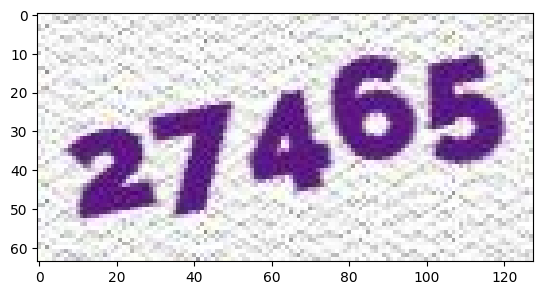

In [29]:
plt.imshow(test_ds[576][0].permute(1, 2, 0) , cmap='gray')

In [30]:
pred[576]

'27465'

In [31]:
updated_pred = ["str" + string for string in pred]
updated_list = [string[-16:] for string in test_list]

In [32]:
df_predict = pd.DataFrame({'Id':updated_list, 'Label': updated_pred})
df_predict.to_csv('/kaggle/working/submission.csv', index=False)

## Logs

In [33]:
#pd.read_csv('/kaggle/input/eventsouttfevents168469181573f73a41f0d0240/events.out.tfevents.1684691815.73f73a41f0d0.24.0')

In [34]:
#%reload_ext tensorboard
#%tensorboard --logdir=/kaggle/input/eventsouttfevents168469181573f73a41f0d0240/

##

In [35]:
#!pip install ngrok

In [36]:
# # Download Ngrok to tunnel the tensorboard port to an external port
# #!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# #!unzip ngrok-stable-linux-amd64.zip

# # Run tensorboard as well as Ngrox (for tunneling as non-blocking processes)
# import os
# import multiprocessing


# pool = multiprocessing.Pool(processes = 10)
# results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
#                         for cmd in [
#                         f"tensorboard --logdir ./kaggle/input/ --host 0.0.0.0 --port 6006 &",
#                         "./ngrok http 6006 &"
#                         ]]

In [37]:
# ! curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"